### Creating a Deep Neural Network from scratch (i.e. using only numpy) to determine whether a given object passing close to earth is hazardous or not.

We will implement a binary classification neural network with two hidden layers and train it using a Kaggle dataset. The project will be divided into sections::

- [0: Data preparation](#1)
- [1: Initialisation of hyperparameters](#2)
- [2: Forward propagation](#3)
- [3: Back propagation](#4)
- [4: Updating parameters](#5)
- [5: Testing and evaluation](#6)

We will use a Neural Network with two hidden layers, each consisting of five nodes. The activation functions are fixed to be LINEAR -> RELU -> RELU -> Sigmoid, although this can be easily generalised.

## 0: Data preparation

We will use the Kaggle dataset 'nearest-earth-objects' which contains data on 300000+ near-earth objects, including a label which tells us if each object is hazardous or not.

In [18]:
# importing the necessary packages
import math
import numpy as np   # for various mathematical operations (e.g. forward and back proagation)
import pandas as pd  # for processing the dataset
import copy

In [19]:
# Loading the dataset
df = pd.read_csv('nearest-earth-objects.csv')

# Naming the columns that are irrelevant for training the NN
columns_to_drop = ['neo_id', 'name', 'orbiting_body', 'is_hazardous'] 

# Dropping the specified columns
ds = df.drop(columns=columns_to_drop)

# Preparing the labels
dy = df['is_hazardous'].values
dy = np.array(dy, dtype = int)

# Prepare the training, validation and test sets
training_set_x = ds.head(50000).T
validation_set_x = ds.loc[270401: 304200].T
test_set_x = ds.loc[304201 : 338000].T

# Prepare the labels for the training, validation and test sets
training_set_y = dy[:50000]   # We choose the first 50000 elements to form the training set.
validation_set_y = dy[270401:304201]
test_set_y = dy[304201 : 338001]

training_set_y = training_set_y.reshape(1,training_set_y.shape[0])
test_set_y = test_set_y.reshape(1,test_set_y.shape[0])
validation_set_y = validation_set_y.reshape(1,validation_set_y.shape[0])

Let's visualise the training set.

In [20]:
print(training_set_x)

                               0             1             2      \
absolute_magnitude      1.914000e+01  1.850000e+01  2.145000e+01   
estimated_diameter_min  3.949617e-01  5.303407e-01  1.363186e-01   
estimated_diameter_max  8.831612e-01  1.185878e+00  3.048176e-01   
relative_velocity       7.174540e+04  1.099498e+05  2.486551e+04   
miss_distance           5.814362e+07  5.580105e+07  6.720689e+07   

                               3             4             5      \
absolute_magnitude      2.063000e+01  2.270000e+01  2.500000e+01   
estimated_diameter_min  1.988635e-01  7.665756e-02  2.658000e-02   
estimated_diameter_max  4.446722e-01  1.714115e-01  5.943469e-02   
relative_velocity       7.889008e+04  5.603652e+04  4.747765e+04   
miss_distance           3.039644e+07  6.311863e+07  4.290521e+07   

                               6             7             8      \
absolute_magnitude      2.150000e+01  1.975000e+01  2.170000e+01   
estimated_diameter_min  1.332156e-01  2.982325

Next, we define the activation functions that we will use.

In [105]:
# Create a class which contains the activation functions we will use

class Activation():

    def __init__(self):
        pass  ## Nothing to initialise

    @staticmethod  # We use a static method since there is no need to reference self.
    def sigmoid(x):
        x = np.clip(x, -500, 500)
        return 1/ (1 + np.exp(-x))

    @staticmethod
    def relu(x):
        return np.maximum(0,x)

    @staticmethod
    def tanh(x):
        return np.tanh(x)

    @staticmethod
    def linear(x):
        return x

    @staticmethod
    def leaky_relu(x, alpha=0.01):
        return np.where(x > 0, x, alpha * x)

## 1: Initialisation
We create a function initialize_parameters which generates the weights for each layer in the network. We use the np.random function and multiply by 0.01 to 'normalise' the data for optimal performance.

In [106]:
# Initialize the hyperparameters

L = 2  # Number of hidden layers
depth_layers = (training_set_x.shape[0], 5, 5, 1) # Dimensions of layers

def initialize_parameters(n_x, n_h):
    # INPUTS
    # n_x = size of input layer (array)
    # layers_h = sizes of hidden layers (array)
    # n_y = size of output layer 
    
    # OUTPUTS
    # dictionary with weights Wi and bi for i = 1, ..., L    

    weights = {}
    for i in range(1, len(n_h)):
        #w_name = f'W{i}'
        weights["W" + str(i)] = np.random.randn(n_h[i], n_h[i-1]) * 0.1

        #b_name = f'b{i}'
        weights["b" + str(i)] = np.zeros((n_h[i], 1))
    
    return weights

## 2: Forward Propagation
Now let's write the function that performs the forward pass.

In [107]:
## Now we create a function which performs a forward pass over one layer

activation_fns = [Activation.leaky_relu, Activation.leaky_relu, Activation.leaky_relu, Activation.sigmoid]

weights = initialize_parameters(training_set_x.shape[0], depth_layers)

def forward(activations, weights, X):
    ## INPUTS:
    # activations: an array which contains the activation functions we will use (in order)
    # weights:  dictionary containing the weights Wi and bi

    ## OUTPUTS:
    # cache: an array containing the outputs (with/without activation) after each layer
    # cache = [Z0, Z1, A1, Z2, A2, Z3, A3]
    cache = {"A0" : X}
    
    for i in range(1, len(depth_layers)):
        #Wi = weights["W" + str(i)]
        cache["Z" + str(i)] = np.dot(weights["W" + str(i)], cache["A" + str(i-1)]) + weights["b" + str(i)]
        cache["A" + str(i)] = activation_fns[i](cache["Z"+str(i)])

    return cache

We will also need a function that computes the cost. For the cost function, we choose the cross-entropy cost $J$, defined as $$ -\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right)) \tag{7}$$

In [83]:
def compute_cost(AL, Y):
    ## INPUTS:
    # AL -- vector corresponding to label predictions, shape (1, number of examples)
    # Y -- true "label" vector (for example: containing 0 if non-hazardous, 1 if hazardous), shape (1, number of examples)

    # OUTPUTS:
    # cost -- cross-entropy cost
    m = Y.shape[1]

    k = 1e-10  # Add k to avoid log(0) errors occuring
    cost = - (np.sum( Y * np.log(AL + k) + (1-Y) * np.log(1-AL +k), axis=1, keepdims = True)) / m
    
    cost = np.squeeze(cost)      # To make sure the cost's shape is as expected (e.g. it turns [[7]] into 7).
    
    return cost

## 3: Back propagation

In this step, we calculate the gradients of our loss function with respect to the activations, weights and biases of each layer.

For each $l$, the three gradients $(dW^{[l]}, db^{[l]}, dA^{[l-1]})$ are computed using the input $dZ^{[l]}$.
Here are the expressions for the gradients:d:
$$ dW^{[l]} = \frac{\partial \mathcal{J} }{\partial W^{[l]}} = \frac{1}{m} dZ^{[l]} A^{[l-1] T} \tag{8}$$
$$ db^{[l]} = \frac{\partial \mathcal{J} }{\partial b^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)}\tag{9}$$
$$ dA^{[l-1]} = \frac{\partial \mathcal{L} }{\partial A^{[l-1]}} = W^{[l] T} dZ^{[l]} \tag{10}$$


$A^{[l-1] T}$ is the transpose of $A^{[l-1]}$. 

Of course, to use these formulas we will first need to compute $dZ^{[l]}$ for each layer $l$. This is done in the backward function below and stored in a dictionary labelled dZ.

In [84]:
## Now we perform the backpropagation
# We will need the derivatives of our activation functions, so let's define those first.

def relu_grad(x):
        return (x > 0) * 1

def sigmoid_grad(x):
        return Activation.sigmoid(x)*(1-Activation.sigmoid(x))

def linear_grad(x):
    return np.ones_like(x)
        
# Now we define a function which does backprop over one layer.
def backward(cache, Y, weights):
    ## INPUTS:
    # cache: a dictionary containing all the weights

    ## OUTPUTS:
    # grads: a dictionary containing all the gradients
    
    m = Y.shape[1]  # letting m be the number of training examples

    # Creating the dictionary dZ which will store the gradients dL/Dz^i
    dZ = {"dZ3" : cache["A" + str(3)] - Y}
    dZ["dZ2"] = np.multiply(np.dot(weights["W" + str(3)].T, dZ["dZ3"]), relu_grad(cache["Z" + str(2)]))
    dZ["dZ1"] = np.dot(weights["W" + str(2)].T, dZ["dZ2"])


    # Y1 and Y2 appear in the cost function, so we define them first for more readable computations.
    Y1 = np.multiply(Y, 1/ (cache["A" + str(3)]))
    Y2 = np.multiply((1-Y), 1 / (cache["A" + str(3)]))
    
    # Now we calculate the gradients for each layer using the formulas above.
    grads = {}
    for i in range (1, len(depth_layers)):
        grads["dW" + str(i)] = ( np.dot(dZ["dZ" + str(i)], cache["A" + str(i-1)].T ) ) / m
        grads["db" + str(i)] = ( np.sum(dZ["dZ" + str(i)], axis=1, keepdims = True) ) / m
        grads["dA" + str(i-1)] = ( np.dot(weights["W" + str(i)].T, dZ["dZ" + str(i)]))

    return grads

## 4: Updating the parameters
We write a function which updates the parameters using a standard gradient descent approach.

Recall that the update rule for gradient descent reads as $$\theta_{k+1} = \theta_{k} - \alpha \nabla \mathcal{J}(\theta_{k}) $$ where $\alpha$ is the learning rate.

In [85]:
def update_parameters(params, grads, learning_rate):
    parameters = copy.deepcopy(params)
    N = len(parameters)

    # Update rule for each parameter
    for l in range(3):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*grads["db" + str(l+1)]
    
    return parameters

In [86]:
def two_layer_model(X, Y, depth_layers, learning_rate = 0.001, num_iterations=2000, print_cost=False):
    """
    Implements a 2-layer neural network: [RELU]*(L-1)->SIGMOID.
    
    INPUTS:
    X -- input data
    Y -- true label vector of shape (1, number of examples)
    depth_layers -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate for the gradient descent update
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    OUTPUTS:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    np.random.seed(1)
    costs = []

    weights = initialize_parameters(training_set_x.shape[0], depth_layers)

    for i in range(0, num_iterations):
        cache = forward(activation_fns, weights, training_set_x)  # Forward pass, returning cache an array of outputs [Z0, A0, ... , Z3 ,A3]
        cost = compute_cost(cache["A" + str(3)], Y)  # Computing the cost
        grads = backward(cache, Y, weights) # Backward pass, returning grads [dWi, dbi, dAi for i = 1,2,3]
        weights = update_parameters(weights, grads, learning_rate)  # Updating the cache array with new parameters.
        
        costs.append(cost)
    
    return cache, costs, weights

# 5: Testing and evaluation

First, we train the model for 500 iterations and evaluate its performance on the test set.

In [99]:
from sklearn.utils import resample

# Combine features and labels for easy resampling
train_data = np.hstack((training_set_x.T, training_set_y.T))  # Convert to shape (N, features + 1)

# Separate majority and minority classes
majority = train_data[train_data[:, -1] == 0]  # Non-hazardous
minority = train_data[train_data[:, -1] == 1]  # Hazardous

# Oversample minority class to match majority size
minority_upsampled = resample(minority, replace=True, n_samples=len(majority), random_state=42)

# Combine back into one dataset
balanced_data = np.vstack((majority, minority_upsampled))
np.random.shuffle(balanced_data)  # Shuffle to mix 0s and 1s

# Separate back into X and Y
training_set_x = balanced_data[:, :-1].T  # Features
training_set_y = balanced_data[:, -1].reshape(1, -1)  # Labels

# Check new class balance
unique, counts = np.unique(training_set_y, return_counts=True)
print(f"Balanced Training Class Distribution: {dict(zip(unique, counts))}")

Balanced Training Class Distribution: {0.0: 42009, 1.0: 42009}


In [ ]:
import matplotlib.pyplot as plt

N = 500

parameters, costs, weights = two_layer_model(training_set_x, training_set_y, (training_set_x.shape[0], 5, 5, 1), learning_rate = 0.05, num_iterations=N)


def plot_costs(costs, N, window=10):
    """
    Plots the evolution of cost with iterations, including a smoothed curve.
    """
    x_range = np.arange(1, N + 1)

    # Compute moving average for smoothing
    smoothed_costs = np.convolve(costs, np.ones(window)/window, mode='valid')

    plt.figure(figsize=(8, 5))
    plt.plot(x_range, costs, label="Raw Cost", alpha=0.5)
    plt.plot(x_range[:len(smoothed_costs)], smoothed_costs, label=f"Smoothed (window={window})", linewidth=2, linestyle="--")

    plt.xlabel('Iterations')
    plt.ylabel('Cost')
    plt.title('Training Cost vs. Iterations')
    plt.yscale("log")  # Log scale for better visibility
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function
plot_costs(costs, N)

# Let's also evaluate the model on the training and test sets.
def predict(weights, X):
    """
    Carries out the forward propagation and returns binary predictions.
    """
    cache = forward(activation_fns, weights, X)
    return (cache["A3"] > 0.5).astype(int)

def compute_accuracy(predictions, labels):
    return np.mean(predictions == labels) * 100

def predict_with_threshold(weights, X, threshold=0.2):
    cache = forward(activation_fns, weights, X)
    return (cache["A3"] > threshold).astype(int)

test_predictions = predict_with_threshold(weights, test_set_x, threshold=0.3)

# Predictions
train_predictions = predict(weights, training_set_x)
test_predictions = predict(weights, test_set_x)

# Accuracy
train_acc = compute_accuracy(train_predictions, training_set_y)
test_acc = compute_accuracy(test_predictions, test_set_y)

print(f"Training Accuracy: {train_acc:.2f}%")
print(f"Test Accuracy: {test_acc:.2f}%")

For imbalanced datasets, the accuracy on the training and test sets may not suffice, so we also calculate precision, recall and the F score. 

In [110]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Convert predictions to 1D arrays
train_preds_flat = train_predictions.flatten()
test_preds_flat = test_predictions.flatten()

# Compute metrics
precision = precision_score(test_set_y.flatten(), test_preds_flat)
recall = recall_score(test_set_y.flatten(), test_preds_flat)
f1 = f1_score(test_set_y.flatten(), test_preds_flat)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

unique, counts = np.unique(test_preds_flat, return_counts=True)
print(f"Prediction Distribution: {dict(zip(unique, counts))}")



Precision: 0.07
Recall: 1.00
F1 Score: 0.13
Prediction Distribution: {0: 2, 1: 33798}


Let's wrap it up by obtaining the confusion matrix.

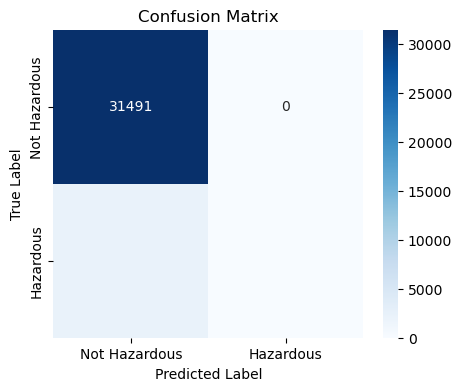

In [97]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(test_set_y.flatten(), test_preds_flat)

# Plot
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Hazardous", "Hazardous"], yticklabels=["Not Hazardous", "Hazardous"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
